# ЦИФРОВОЙ ПРОРЫВ 2022

# Региональный чемпионат республики Карелия

## Прогнозирование оттока пользователей провайдера телекоммуникационных услуг

Сфера телекоммуникаций — высококонкурентная динамичная среда, в которой уровень осведомленности пользователей позволяет легко получить информацию о других поставщиках услуг с аналогичным или наиболее высоким качеством по более выгодной цене. Отсюда и возникает проблема оттока пользователей.

Для любого провайдера важным аспектом является пользовательская база. В нее поступают новые пользователи, какое-то время активно потребляют услуги и через некоторый промежуток времени перестают, этот промежуток называется «жизненный цикл клиента». Отток пользователей выражается в сокращении пользовательской базы и снижении показателей выручки.

Анализ пользовательского поведения и удержание пользователей важно по ряду причин: - понимание причин ухода пользователей — ключ к улучшению продуктов и услуг. В современном мире темпы роста постоянно ускоряются, рынок заполнен огромным количеством конкурентов, что приводит к постоянному повышению требований потребителей к продукции и услугам; - привлечение новых пользователей дороже процедур удержания. На привлечение новых пользователей, как правило, нужно заложить рекламный бюджет, в то время как существующих можно активизировать специальным предложением с особыми условиями.

Анализ данных о пользовательском поведении по косвенным признакам — одна из самых востребованных на сегодняшний день технологий не только у бизнеса, но и у государственных структур. Она позволит определять востребованные пользователем услуги, а также поможет в реализации персонализированного уникального подхода к запросам граждан.

# Описание задачи


**Задача: создать решение по прогнозированию оттока с использованием данных о клиентах.**

В нашем распоряжении находится файлы с информацией о запросах пользователей к сайтам конкурентов и история обращений в компанию.

Описание входных значений:

файл **train.csv** — содержит данные пользователей (для обучения модели):
* ***contract_id*** - идентификатор пользователя (контракта пользователя)
* ***blocked:***:  1 - клиент ушел, 0 - остался

файл **log.csv**  — содержит данные обращения пользователей:
* ***contract_id*** - идентификатор пользователя (контракта пользователя)
* ***event_date*** - дата обращения пользователя
* ***event_type*** - тип обращения пользователя

файл **named.csv** — содержит лог днс-запросов к доменам конкурентов (rt.ru и sampo.ru):
* ***contract_id*** - идентификатор пользователя (контракта пользователя)
* ***date*** - дата сеанса пользователя
* ***url*** - адрес сайта

файл **type contract.csv** - содержит тип списания у пользователей:
* ***contract_id*** - идентификатор пользователя (контракта пользователя)
* ***day_or_month_contract*** 1 - посуточная, 0 - помесячная

файл **sample_solution.csv** — содержит данные с **contract_id** пользователей (для тестирования модели) и одновременно является файлом - примером для отправки результата.

**В качестве метрики выступает Recall по столбцу blocked.**


# Этапы реализации:
1. Провести обзор и анализ предоставленных данных.
2. Определить и сформировать признаки для формирования обучающей выборки (feature extraction & feature engineering). 
3. Устранить дисбаланс классов в выборке, при его наличии (oversampling).
4. Определить модель машинного обучения: алгоритм, обучение, кроссвалидация (machine learning).
5. Сформировать результат по тестовой выборке (submit).

# 1. Обзор и анализ данных

**Импортируем все, необходимые библиотеки и модули**

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from catboost import CatBoostClassifier, Pool

%matplotlib inline

**Загрузка данных в датафреймы (файлы должны быть расположены в директории данного решения, либо необходимо указать соответствующие пути к файлам)**

In [2]:
%%time
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('sample_solution.csv')
named_df = pd.read_csv('named.csv')
type_contract_df = pd.read_csv('type_contract.csv')
log_df = pd.read_csv('log.csv')

Wall time: 3.49 s


In [3]:
train_df.info() # смотрим общее описание

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5992 entries, 0 to 5991
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   contract_id  5992 non-null   int64
 1   blocked      5992 non-null   int64
dtypes: int64(2)
memory usage: 93.8 KB


In [4]:
train_df.head(3) # смотрим первые записи 

,contract_id,blocked
0,7780,0
1,7785,0
2,7794,0


In [5]:
train_df.blocked.value_counts()

0    5294
1     698
Name: blocked, dtype: int64

In [6]:
test_df.info() # смотрим общее описание

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   contract_id  810 non-null    int64
 1   blocked      810 non-null    int64
dtypes: int64(2)
memory usage: 12.8 KB


In [7]:
test_df.head(3) # смотрим первые записи 

,contract_id,blocked
0,3453,0
1,3454,0
2,3455,0


In [8]:
named_df.info() # смотрим общее описание

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10646537 entries, 0 to 10646536
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   date         object
 1   url          object
 2   contract_id  int64 
dtypes: int64(1), object(2)
memory usage: 243.7+ MB


In [9]:
named_df.head(3) # смотрим первые записи 

,date,url,contract_id
0,17-Apr-2021,webmail.sampo.ru,101397
1,17-Apr-2021,webmail.sampo.ru,179624
2,17-Apr-2021,tvip-provision.sampo.ru,190335


In [10]:
log_df.info() # смотрим общее описание

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25274 entries, 0 to 25273
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   contract_id  25274 non-null  int64 
 1   event_date   25274 non-null  object
 2   event_type   25274 non-null  object
dtypes: int64(1), object(2)
memory usage: 592.5+ KB


In [11]:
log_df.head(3) # смотрим первые записи 

,contract_id,event_date,event_type
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета


In [12]:
log_df.event_type.nunique() # всего разных типов обращений

105

In [13]:
type_contract_df.info() # смотрим общее описание

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6805 entries, 0 to 6804
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   contract_id            6805 non-null   int64
 1   day_or_month_contract  6805 non-null   int64
dtypes: int64(2)
memory usage: 106.5 KB


In [14]:
type_contract_df.head(3) # смотрим первые записи 

,contract_id,day_or_month_contract
0,7780,0
1,3996,0
2,7785,0


**Из описания файлов и датафреймов делаем два вывода**
* все новые признаки для обучающей и тестовой выборок возможно конкатенировать по столбцу **contract_id**
* присутствует явный дисбаланс классов в обучающем наборе (5294 - 0 и 698 - 1), запомним и постараемся учесть это при обучении модели 

# 2. Feature extraction & Feature engineering

## 2.1. Объединение обучающей и тестовой выборки
Объедеиним данный в общий датафрейм, затем будем наполнять его признаками (features), запомним позицию **5992** для последующего разделения данных

In [15]:
all_df = pd.concat([train_df, test_df], ignore_index=True)
all_df

,contract_id,blocked
0,7780,0
1,7785,0
2,7794,0
3,7795,0
4,7798,0
...,...,...
6797,4258,0
6798,4259,0
6799,4260,0
6800,4261,0


## 2.2. Работа с type_contract_df

Начнем с type_contract_df, тут всё очевидно, по столбцу **contract_id** сформируем признак **day_or_month_contract** как есть

In [16]:
all_df = pd.merge(all_df, type_contract_df, on="contract_id", how='left').drop_duplicates(subset="contract_id", ignore_index=True)
all_df.info() # смотрим описание

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6802 entries, 0 to 6801
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   contract_id            6802 non-null   int64  
 1   blocked                6802 non-null   int64  
 2   day_or_month_contract  6800 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 159.5 KB


In [17]:
all_df.head(3) # смотрим первые записи

,contract_id,blocked,day_or_month_contract
0,7780,0,0.0
1,7785,0,0.0
2,7794,0,0.0


In [18]:
all_df.day_or_month_contract.fillna(0, inplace=True) # заполняем два пропуска нулями
all_df.day_or_month_contract = all_df.day_or_month_contract.astype('int64') # приводим столбец к целочисленному типу

In [19]:
all_df.head(3) # смотрим первые записи

,contract_id,blocked,day_or_month_contract
0,7780,0,0
1,7785,0,0
2,7794,0,0


## 2.3. Работа с named_df

Анализ named_df приводит к идее сформировать следующий признак - **количество запросов пользователя к сайтам, которые посещали ушедшие (blocked - 1) пользователи**. Так как при это есть данные о дате, тот разобьём данный признак на три периода, в первые две недели, вторые две недели и последние две недели в имеющихся данных. Для этого сначала сформируем столбец **week** в named_df, затем присоеденим по **contract_id** значение из train_df столбца **blocked**, после проведем необходимые группировки и трансформации для создания трёх новых признаков.

In [20]:
named_df['date'] = pd.to_datetime(named_df['date']) # приводим столбец date к типу datetime 
named_df['week'] = named_df['date'].dt.isocalendar().week.astype('int64') # формируем столбец с номером недели

In [21]:
named_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10646537 entries, 0 to 10646536
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   url          object        
 2   contract_id  int64         
 3   week         int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 324.9+ MB


In [22]:
sorted(named_df.week.unique()) # смотрим какие есть недели в данных

[12, 13, 14, 15, 16, 17]

In [23]:
temp1 = pd.merge(named_df[['contract_id', 'url']], train_df, on="contract_id", how='left') # формируем промежуточнй датафрейм со столбцом blocked 
temp1 = temp1[temp1.blocked == 1] # оставляем только те строки, где в blocked 1
temp1 = temp1.rename(columns={'blocked': 'cat_url'}).reset_index()
temp1 = temp1[['url', 'cat_url']].drop_duplicates().reset_index(drop=True)
temp1.head(3) # получили промежуточные данные по категории сайтов 1

,url,cat_url
0,sampo.ru,1.0
1,hosting.sampo.ru,1.0
2,webmail.sampo.ru,1.0


In [24]:
%%time
named_df = pd.merge(named_df, temp1, on="url", how='left').fillna(0) # формируем столбец cat_url
named_df.cat_url = named_df.cat_url.astype('int64')
named_df.head(3)

Wall time: 37.1 s


,date,url,contract_id,week,cat_url
0,2021-04-17,webmail.sampo.ru,101397,15,1
1,2021-04-17,webmail.sampo.ru,179624,15,1
2,2021-04-17,tvip-provision.sampo.ru,190335,15,0


In [25]:
%%time
for i in (12, 14, 16): # формируем три новых признака 
    temp2 = named_df[((named_df['week'] == i) | (named_df['week'] == i + 1)) & (named_df['cat_url'] == 1)].groupby('contract_id').count()
    temp2 = temp2.drop(['date', 'url', 'week'], axis=1).rename(columns={'cat_url': f'period_{i}_count_cat_url_1'})
    all_df = pd.merge(all_df, temp2, on='contract_id', how='left')
    all_df[f'period_{i}_count_cat_url_1'] = all_df[f'period_{i}_count_cat_url_1'].fillna(0).astype('int64')


Wall time: 814 ms


In [26]:
all_df.head(3)

,contract_id,blocked,day_or_month_contract,period_12_count_cat_url_1,period_14_count_cat_url_1,period_16_count_cat_url_1
0,7780,0,0,0,0,83
1,7785,0,0,7,0,3
2,7794,0,0,0,0,0


**Сформированы три новых признака - количество запросов к сайтам категории 1 по каждому двухнедельному периоду.**

<div class="alert alert-info">
<b>Примечание 1:</b>
 следует отметить, что в рабочем процессе формировались и 6 признаков - по каждой неделе, и 2 признака - весь интервал разбивался на 2 периода, но лучшие результаты показала модель, обученная с учетом признаков, сформированных именно по трём периодам

## 2.4. Работа с log_df

Анализ log_df приводит к идее сформировать следующий признак - количество обращений пользователя по типам обращений, которые делали ушедшие (blocked - 1) пользователи. Дату и время обращения учитывать не будем, вместо этого сначала разобьем типы обращений на три категории в зависимости от частоты обращения - отношение количества обращений ушедших пользователей ко всем пользователям.

In [27]:
log_df['event_date'] = pd.to_datetime(log_df['event_date']) # приводим столбец к типу datetime
log_df = log_df[log_df.event_type != 'Турбокнопка бесплатно'] # удаляем не релевантный тип обращения
log_df = log_df[log_df.event_type != 'Турбокнопка платно (1 сутки)'] # удаляем не релевантный тип обращения
log_df = log_df[log_df.event_type != 'Турбокнопка платно (1 час)'] # удаляем не релевантный тип обращения
log_df = log_df[log_df.event_type != 'Включение автоматической активации ГП'] # удаляем не релевантный тип обращения
log_df = log_df[log_df.event_type != 'Тайный покупатель. Отправлена анкета'] # удаляем не релевантный тип обращения

In [28]:
temp3 = pd.merge(log_df, train_df, on="contract_id", how='left')
temp3 = temp3[~temp3.blocked.isna()]
temp4 = temp3.groupby('event_type').mean().sort_values(by='blocked', ascending=False)
temp4[55:65] # получили в столбце blocked данной групиировки среднее, по которому определим категории типов обращений

,contract_id,blocked
event_type,,
Без границ бесплатно. Отключение,32847.000000,0.130435
Активация ГП с IVR,62210.591549,0.126761
Включение интернета на 20 минут,51104.187877,0.124246
Включение IPTV-пакета,55417.692810,0.124183
Предложение тарифа,49837.556886,0.107784
Выключение IPTV-пакета,50858.930233,0.104651
Уведомления: подтверждение,34762.400000,0.100000
Информер ВК. Показ,47680.935655,0.097736
Предложение ТВ-пакета,50149.777778,0.083333


In [29]:
def cat_even(x): # функция, котороя в зависимости от порогового значения среднего определяет категорию
    if x < 0.001:
        return 0
    if x < 0.124:
        return 1
    return 2

<div class="alert alert-info">
<b>Примечание 2:</b>
 следует отметить, что пороговое значение для разбивки типов обращений по категориям сначала было определено интуитивно 0.20, а затем при валидации модели этот порог итеративно (методом половинного деления) был переопределен на 0.124 - что показывало лучший результат. Также, в результате отсеивания категорий с низким средним были определены нерелевантные типы обращений: 'Турбокнопка бесплатно', 'Турбокнопка платно (1 сутки)', 'Турбокнопка платно (1 час)' и др., которые по сути были переведены в нулевую категорию.

In [30]:
temp4['cat_even'] = temp4['blocked'].map(cat_even) 
temp4 = temp4.drop(['contract_id', 'blocked'], axis=1)
temp4 # присвоили каждому обращению категорию

,cat_even
event_type,
Блокировка,2
Расторжение,2
Отключение ограничения функций ТВ,2
Отмена гарантированного платежа,2
Виртуальное бессмертие. Отключение,2
...,...
Подписка на ivi. Включение триала,0
Общий счет. Отсоединение реципиента,0
Окончание рассрочки за подключение,0


In [31]:
log_df = pd.merge(log_df, temp4, on="event_type", how='left').fillna(0)
log_df # сформировали в log_df столбец с категорией обращения

,contract_id,event_date,event_type,cat_even
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров,2.0
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах,2.0
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета,1.0
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета,2.0
4,36294,2021-03-28 16:35:04,Обращение в службу заботы о клиентах,2.0
...,...,...,...,...
24374,11801,2021-04-29 07:50:44,Информер ВК. Показ,1.0
24375,54405,2021-03-17 10:38:42,Информер ВК. Показ,1.0
24376,54405,2021-03-23 08:21:29,Информер ВК. Показ,1.0
24377,54405,2021-04-09 13:04:26,Информер ВК. Показ,1.0


In [32]:
log_df[log_df['cat_even'] == 1].groupby('contract_id').count()

,event_date,event_type,cat_even
contract_id,,,
3453,1,1,1
3457,4,4,4
3459,3,3,3
3462,1,1,1
3465,3,3,3
...,...,...,...
273908,3,3,3
274321,3,3,3
274601,1,1,1


In [33]:
%%time
for i in (1, 2):
    temp5 = log_df[log_df['cat_even'] == i].groupby('contract_id').count()
    temp5 = temp5.drop(['event_date', 'event_type'], axis=1).rename(columns={'cat_even': f'cat_even_{i}'})
    all_df = pd.merge(all_df, temp5, on='contract_id', how='left')
    all_df[f'cat_even_{i}'] = all_df[f'cat_even_{i}'].fillna(0).astype('int64')

Wall time: 10 ms


In [34]:
all_df

,contract_id,blocked,day_or_month_contract,period_12_count_cat_url_1,period_14_count_cat_url_1,period_16_count_cat_url_1,cat_even_1,cat_even_2
0,7780,0,0,0,0,83,0,9
1,7785,0,0,7,0,3,0,1
2,7794,0,0,0,0,0,0,0
3,7795,0,1,0,0,0,3,4
4,7798,0,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...
6797,4258,0,1,0,0,0,0,3
6798,4259,0,1,44,115,73,0,0
6799,4260,0,0,0,0,9,3,0
6800,4261,0,0,0,0,0,2,16


## 2.5. Разделение датафрейма на выборки

In [35]:
train = all_df[:5992]
test = all_df[5992:] 

In [36]:
print(train_df.shape, test_df.shape)

(5992, 2) (810, 2)


In [37]:
X = train.drop(["contract_id", "blocked"], axis = 1)
y = train["blocked"]
X_test = test.drop(["contract_id", "blocked"], axis = 1).reset_index(drop=True)

In [38]:
X

,day_or_month_contract,period_12_count_cat_url_1,period_14_count_cat_url_1,period_16_count_cat_url_1,cat_even_1,cat_even_2
0,0,0,0,83,0,9
1,0,7,0,3,0,1
2,0,0,0,0,0,0
3,1,0,0,0,3,4
4,0,0,0,0,3,0
...,...,...,...,...,...,...
5987,1,0,0,0,1,5
5988,0,0,0,0,1,6
5989,0,0,0,0,0,8
5990,1,0,1,0,2,7


### Таким образом, мы получили обучающую выбоку с шестью признаками 

# 3. Oversampling (устранение дисбаланса классов)

Для устранение дисбаланса классов воспльзуемся **BorderlineSMOTE** из библиотеки **imblearn**, этот алгоритм является вариантом оригинального алгоритма SMOTE (синтезирования образцов наименьшего класса), который вместо избыточной выборки между всеми наблюдениями меньшенства, BorderlineSMOTE стремится увеличить количество наблюдений меньшенства, которые граничат с наблюдениями большинства. Цель здесь - дать классификатору возможность более четко различать эти пограничные наблюдения.

In [39]:
bl = BorderlineSMOTE(random_state=42, sampling_strategy=0.66)
X_res, y_res = bl.fit_resample(X, y)
print(sorted(Counter(y_res).items()))

[(0, 5294), (1, 3494)]


<div class="alert alert-info">
<b>Примечание 3:</b>
 следует отметить, что значение параметра sampling_strategy (пропорция образцов меньшего класса к большему после применения) определялось итеративно (методом половинного деления), в резултате, на валидации лучшее значение оказалось равное 0.66

# 4. Machine Learning (выбор и обучение модели)

Так как нами решается задача бинарной классификации, то для модели машинного обучения используем градиентый бустинг и его одну из наилучших реализаций **CatBoost** разработки компании **Яндекс**  

## 4.1. Обучение модели и валидация

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X_res, y_res, test_size=0.25, stratify=y_res, random_state=12345)

In [41]:
pool_train = Pool(X_train, y_train)
pool_valid = Pool(X_valid)

In [42]:
CBC = CatBoostClassifier(iterations = 230, learning_rate=0.0005, verbose=False, loss_function = 'MultiClassOneVsAll')
CBC.fit(pool_train)

y_pred_valid = CBC.predict(pool_valid)
y_pred_train = CBC.predict(pool_train)
print("Значение метрики Recall на valid: ", recall_score(y_valid, y_pred_valid, average='macro'))
print("Значение метрики Recall на test: ", recall_score(y_train, y_pred_train, average='macro'))

Значение метрики Recall на valid:  0.7998264483688222
Значение метрики Recall на test:  0.8012656445662192


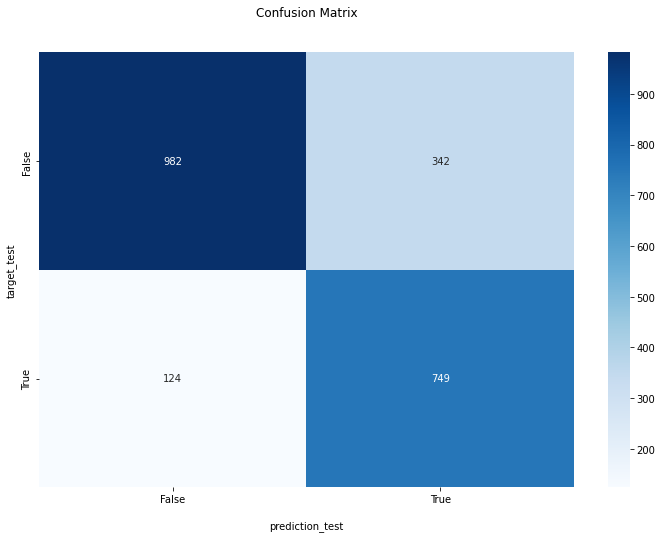

In [43]:
cf_matrix = confusion_matrix(y_valid, y_pred_valid)
plt.figure(figsize=(12,8))
ax = sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nprediction_test')
ax.set_ylabel('target_test');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [44]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,
          'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data) 
    fi_df.sort_values(by=['feature_importance'],    
                     ascending=False,inplace=True)
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], 
               y=fi_df['feature_names'])
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
importances = CBC.feature_importances_
feature_list = list(X.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results.head(10)

,feature,importance
0,cat_even_2,61.299738
1,period_16_count_cat_url_1,21.854231
2,period_12_count_cat_url_1,6.593184
3,cat_even_1,5.505426
4,period_14_count_cat_url_1,3.503460
5,day_or_month_contract,1.243961


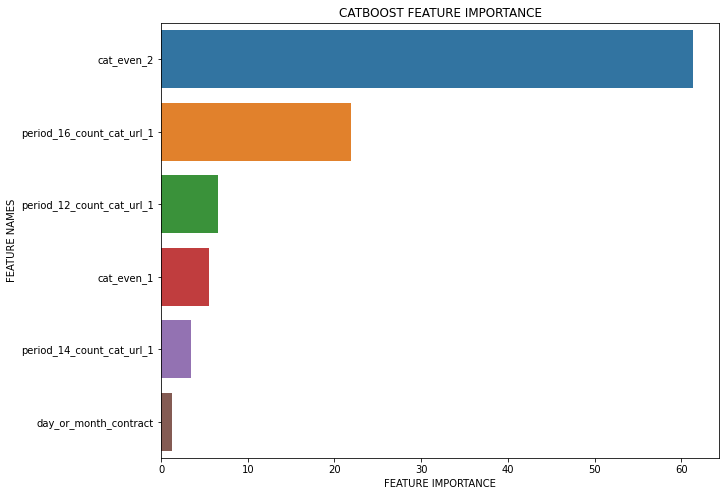

In [45]:
plot_feature_importance(CBC.get_feature_importance(), X.columns,'CATBOOST')

## 4.2. Подбор гиперпараметров

**Пример того, как происводился подбор гиперпараметров**

<div class="alert alert-info">
<b>Примечание 4:</b>
 следует отметить, что в рабочем процессе проверялись модели с использованием: <b>RandomForestClassifier</b>, <b>LogisticRegression</b> и <b>XGBoost</b>

# 5. Обучение модели на всем объеме и формирование результата

In [46]:
pool_train = Pool(X_res, y_res)
CBC.fit(pool_train)
pool_test = Pool(X_test)
pred_cb = CBC.predict(pool_test)

In [47]:
pred_cb.sum()

240

In [48]:
submit = pd.read_csv("sample_solution.csv")
submit["blocked"] = pred_cb
submit.to_csv('submit_cb.csv', index=False)

## Резултат на public leaderboard ~0.822

# P.S. Как классификатор предсказывает обучающую выборку

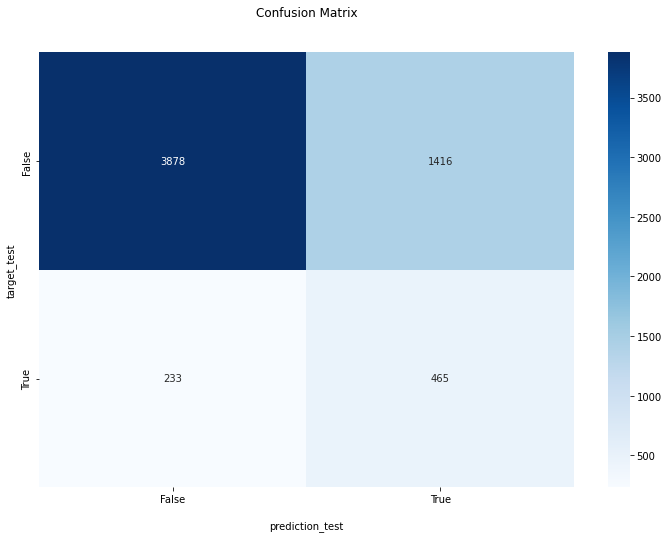

In [51]:
pred =  CBC.predict(Pool(X))
cf_matrix = confusion_matrix(y, pred)
plt.figure(figsize=(12,8))
ax = sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nprediction_test')
ax.set_ylabel('target_test');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()